In [1]:
%%capture
!pip install pandas
!pip install numpy
!pip install tensorflow
!pip install keras
!pip install sklearn
!pip install matplotlib
!pip install seaborn
!pip install unidecode
!pip install -U imbalanced-learn
!pip3 install pickle5

In [2]:
import tensorflow as tf
import pandas as pd
import warnings
import unidecode
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle5 as pickle
import random
import os
import re
import time
import nltk
nltk.download('stopwords')
sns.set_style('darkgrid')

from imblearn.over_sampling import RandomOverSampler
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Reshape, Dense, Dropout, Flatten, Input, MaxPooling2D, Convolution2D, Embedding, Concatenate
from keras.regularizers import l2
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import f1_score, confusion_matrix

sw = set(stopwords.words('english'))
os.environ['PYTHONHASHSEED']=str(23)
tf.random.set_seed(23)
random.seed(23)
warnings.filterwarnings('ignore')
np.random.seed(23)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Preprocessing

In [3]:
def remove_username(text):
  text = re.sub(r'\@[^\s]+', ' ', text)
  return text

def remove_newline(text):
  text = text.replace('\n', ' ')
  return text

def only_letters(text):
  text = re.sub(r'[^a-záâàãéêèẽíìîĩóòõôúùũû\s]+', ' ', text)
  return text

def remove_link(text):
  text = re.sub(r'www\.?[^\s]+', ' ', text)
  return text

def remove_hyperlink(text):
  text = re.sub(r'\<.?\>', ' ', text)
  return text

def remove_accent(text):
  text = unidecode.unidecode(text)
  return text

def adjustment_text(text):
  text = re.sub(r'\s+', ' ', text)
  text = text.strip()
  return text

def remove_stopwords(text):
  text = [word for word in text.split() if word not in sw]
  text = ' '.join(text)
  return text

def remove_spam(text):
  text = re.sub(r'\&amp', ' ', text)
  text = re.sub(r'\&lt', ' ', text)
  text = re.sub(r'\&gt', ' ', text)
  text = re.sub(r'\#follow|\#followme|\#like|\#f4f|\#photooftheday', ' ', text)
  return text

def remove_slangs(text):
  text = re.sub(r' b4 ', ' before ', text)
  text = re.sub(r' 2b ', ' to be ', text)
  text = re.sub(r' 2morrow ', ' tomorrow ', text)
  text = re.sub(r' rn ', ' right now ', text)
  text = re.sub(r' brb ', ' be right back ', text)
  text = re.sub(r' mb ', ' my bad ', text)
  text = re.sub(r' luv ', ' love ', text)
  text = re.sub(r' b ', ' be ', text)
  text = re.sub(r' r ', ' are ', text)
  text = re.sub(r' u ', ' you ', text)
  text = re.sub(r' y ', ' why ', text)
  text = re.sub(r' ur ', ' your ', text)
  text = re.sub(r' hbd ', ' happy birthday ', text)
  text = re.sub(r' bday ', ' birthday ', text)
  text = re.sub(r' bihday ', ' birthday ', text)
  text = re.sub(r' omg ', ' oh my god ', text)
  text = re.sub(r' lol ', ' laughing out loud ', text)
  return text

def remove_abbreviations(text):
  text = re.sub(r" can\'t ", " can not ", text)
  text = re.sub(r" i\'m ", " i am ", text)
  text = re.sub(r" i\'ll ", " i will ", text)
  text = re.sub(r" i\'d ", " i would ", text)
  text = re.sub(r" i\'ve ", " i have ", text)
  text = re.sub(r" ain\'t ", " am not ", text)
  text = re.sub(r" haven\'t ", " have not ", text)
  text = re.sub(r" hasn\'t ", " has not ", text)
  text = re.sub(r" can\'t ", " can not ", text)
  text = re.sub(r" won\'t ", " will not ", text)
  text = re.sub(r" you\'re ", " you are ", text)
  text = re.sub(r" we\'re ", " we are ", text)
  text = re.sub(r" they\'re ", " they are ", text)
  text = re.sub(r" he\'s ", " he is ", text)
  text = re.sub(r" she\'s ", " she is ", text)
  text = re.sub(r" it\'s ", " it is ", text)
  text = re.sub(r" don\'t ", " do not ", text)
  text = re.sub(r" doesn\'t ", " does not ", text)
  text = re.sub(r" wouldn\'t ", " would not ", text)
  text = re.sub(r" couldn\'t ", " could not ", text)
  text = re.sub(r" shouldn\'t ", " should not ", text)
  return text

def remove_one_len_word(text):
  text = re.sub(r'\b[a-z]\b', ' ', text)
  return text

def preprocessing(data):
  data['cleaned_tweet'] = data['tweet'].apply(str)
  data['cleaned_tweet'] = data['cleaned_tweet'].apply(lambda x: x.lower())
  data['cleaned_tweet'] = data['cleaned_tweet'].apply(remove_newline)
  data['cleaned_tweet'] = data['cleaned_tweet'].apply(remove_hyperlink)
  data['cleaned_tweet'] = data['cleaned_tweet'].apply(remove_spam)
  data['cleaned_tweet'] = data['cleaned_tweet'].apply(remove_link)
  data['cleaned_tweet'] = data['cleaned_tweet'].apply(remove_username)
  data['cleaned_tweet'] = data['cleaned_tweet'].apply(remove_abbreviations)
  data['cleaned_tweet'] = data['cleaned_tweet'].apply(only_letters)
  data['cleaned_tweet'] = data['cleaned_tweet'].apply(remove_accent)
  data['cleaned_tweet'] = data['cleaned_tweet'].apply(remove_slangs)
  data['cleaned_tweet'] = data['cleaned_tweet'].apply(remove_stopwords)
  data['cleaned_tweet'] = data['cleaned_tweet'].apply(remove_one_len_word)
  data['cleaned_tweet'] = data['cleaned_tweet'].apply(adjustment_text)
  return data

from google.colab import files
uploaded = files.upload()

!unzip tokenizer_RNN_seed23

In [4]:
normal_data = pd.read_csv('Data/train.csv')
normal_data = normal_data.drop(columns=['id'])
normal_data.head()

,label,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation


In [5]:
normal_data.shape

(31962, 2)

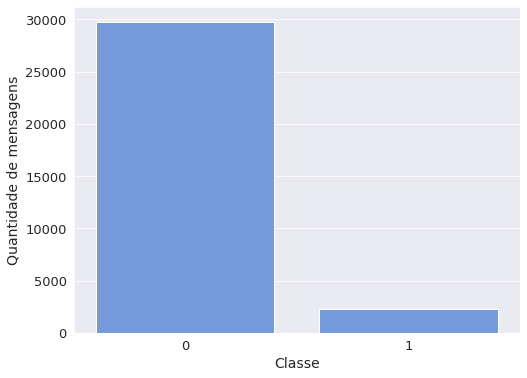

In [6]:
plt.figure(figsize=(8, 6))
sns.countplot(data=normal_data, x='label', color='cornflowerblue')
plt.xlabel('Classe', fontsize=14)
plt.xticks(fontsize=13)
plt.ylabel('Quantidade de mensagens', fontsize=14)
plt.yticks(fontsize=13)
plt.savefig('Images/data_unbalanced.png')

In [7]:
ros = RandomOverSampler(random_state=23, sampling_strategy='minority')
X_resampled, y_resampled = ros.fit_resample(normal_data[['tweet']], normal_data['label'])
data_augmentation = pd.concat([X_resampled, y_resampled], axis=1)
data_augmentation.head()

,tweet,label
0,@user when a father is dysfunctional and is s...,0
1,@user @user thanks for #lyft credit i can't us...,0
2,bihday your majesty,0
3,#model i love u take with u all the time in ...,0
4,factsguide: society now #motivation,0


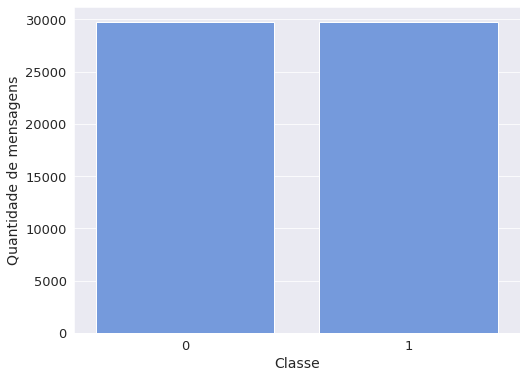

In [8]:
plt.figure(figsize=(8, 6))
sns.countplot(data=data_augmentation, x='label', color='cornflowerblue')
plt.xlabel('Classe', fontsize=14)
plt.xticks(fontsize=13)
plt.ylabel('Quantidade de mensagens', fontsize=14)
plt.yticks(fontsize=13)
plt.savefig('Images/data_balanced.png')

In [9]:
data_augmentation.shape

(59440, 2)

In [10]:
preprocessed_data = normal_data.copy()
preprocessed_data = preprocessing(preprocessed_data)
preprocessed_data = preprocessed_data.replace('None', pd.NA)
preprocessed_data = preprocessed_data.dropna()
preprocessed_data = preprocessed_data.drop_duplicates()
preprocessed_data = preprocessed_data.drop(columns=['tweet'])
preprocessed_data = preprocessed_data.rename(columns={'cleaned_tweet': 'tweet'})
preprocessed_data.head()

,label,tweet
0,0,father dysfunctional selfish drags kids dysfun...
1,0,thanks lyft credit use cause offer wheelchair ...
2,0,birthday majesty
3,0,model love take time
4,0,factsguide society motivation


In [11]:
preprocessed_data.shape

(29530, 2)

In [12]:
ros = RandomOverSampler(random_state=23, sampling_strategy='minority')
X_resampled, y_resampled = ros.fit_resample(preprocessed_data[['tweet']], preprocessed_data['label'])
data_preprocessing_augmentation = pd.concat([X_resampled, y_resampled], axis=1)
data_preprocessing_augmentation.head()

,tweet,label
0,father dysfunctional selfish drags kids dysfun...,0
1,thanks lyft credit use cause offer wheelchair ...,0
2,birthday majesty,0
3,model love take time,0
4,factsguide society motivation,0


In [13]:
data_preprocessing_augmentation.shape

(55034, 2)

## Tokenizer

with open(r"Tokenizer/tokenizer_non_static.pickle", "rb") as output_file:
    tokenizer_non_static = pickle.load(output_file)

with open(r"Tokenizer/tokenizer_non_static_augmentantion.pickle", "rb") as output_file:
    tokenizer_non_static_augmentation = pickle.load(output_file)

with open(r"Tokenizer/tokenizer_non_static_preprocessing.pickle", "rb") as output_file:
    tokenizer_non_static_preprocessing = pickle.load(output_file)

with open(r"Tokenizer/tokenizer_non_static_preprocessing_augmentantion.pickle", "rb") as output_file:
    tokenizer_non_static_preprocessing_augmentation = pickle.load(output_file)

with open(r"Tokenizer/tokenizer_rand.pickle", "rb") as output_file:
    tokenizer_rand = pickle.load(output_file)

with open(r"Tokenizer/tokenizer_rand_augmentantion.pickle", "rb") as output_file:
    tokenizer_rand_augmentation = pickle.load(output_file)

with open(r"Tokenizer/tokenizer_rand_preprocessing.pickle", "rb") as output_file:
    tokenizer_rand_preprocessing = pickle.load(output_file)

with open(r"Tokenizer/tokenizer_rand_preprocessing_augmentantion.pickle", "rb") as output_file:
    tokenizer_rand_preprocessing_augmentation = pickle.load(output_file)

In [14]:
with open(r"content/Tokenizer/tokenizer.pickle", "rb") as output_file:
    tokenizer_lstm = pickle.load(output_file)

In [15]:
all_messages = pd.concat([data_preprocessing_augmentation,
                          preprocessed_data,
                          normal_data,
                          data_augmentation], axis=0)

all_messages = all_messages.reset_index(drop=True)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_messages['tweet'].values)

In [16]:
with open('Tokenizer/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [17]:
teste = pd.DataFrame({'tweet': ["the next school year is the year for exams.ð¯ can't think about that ð­ #school #exams   #hate #imagine #actorslife #revolutionschool #girl",
                                "we won!!! love the land!!! #allin #cavs #champions #cleveland #clevelandcavaliers  â¦ ",
                                "it was a hard monday due to cloudy weather. disabling oxygen production for today. #goodnight #badmonday "]})

teste['tokenized_cnn'] = tokenizer.texts_to_sequences(teste['tweet'].values)
teste['tokenized_lstm'] = tokenizer_lstm.texts_to_sequences(teste['tweet'].values)
teste.head()

,tweet,tokenized_cnn,tokenized_lstm
0,the next school year is the year for exams.ð...,"[2, 145, 203, 117, 10, 2, 117, 11, 3022, 8525,...","[2, 145, 203, 117, 10, 2, 117, 11, 3022, 8525,..."
1,we won!!! love the land!!! #allin #cavs #champ...,"[44, 798, 12, 2, 963, 11131, 1758, 5505, 1195,...","[44, 798, 12, 2, 963, 11131, 1758, 5505, 1195,..."
2,it was a hard monday due to cloudy weather. di...,"[22, 65, 4, 319, 371, 1058, 3, 4752, 1420, 182...","[22, 65, 4, 319, 371, 1058, 3, 4752, 1420, 182..."


In [18]:
teste['tokenized_lstm'].equals(teste['tokenized_cnn'])

True

## Word2vec

with open(r"Data/word2vec.pickle", "rb") as output_file:
    word2vec_embedding = pickle.load(output_file)

with open(r"Data/word2vec_preprocessing.pickle", "rb") as output_file:
    word2vec_preprocessing_embedding = pickle.load(output_file)

In [19]:
with open(r"Data/word2vec_total.pickle", "rb") as output_file:
    word2vec = pickle.load(output_file)

## Parameters

In [20]:
non_linearity_function = 'relu'
kernel_size = [3, 4, 5]
filters = 100
dropout_rate = 0.5
l2_constraint = 3
epochs = 10
batch_size = 100
embedding_dim = 300
length_size = 30

## Tokenization + padding + splitting data step

In [21]:
def preprocessing_step(tokenizer, data, model, preprocessing, augmentation):
  # tokenizer = Tokenizer()
  # tokenizer.fit_on_texts(data['tweet'].values)

  data['tokenized'] = tokenizer.texts_to_sequences(data['tweet'].values)

  vocab_size = len(tokenizer.word_index) + 1

  X = pad_sequences(sequences = data['tokenized'],
                  maxlen = length_size,
                  padding = 'post')

  y = data['label']

  X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.15, random_state=23)

  return vocab_size, tokenizer, X_train, X_validation, y_train, y_validation

In [22]:
def generate_cm(model, X_validation, y_validation, prep, augmentation, nome):

  plt.figure(figsize = (10, 7))
  predicted_validation = (model.predict(X_validation) > 0.5).astype("int32")
  matrix = confusion_matrix(y_validation, predicted_validation, labels=[0, 1])
  sns.set(font_scale=1.4)
  sns.heatmap(matrix, annot=True, cmap="Blues", fmt='d', annot_kws={"size": 16})
  plt.xlabel('Classe prevista')
  plt.ylabel('Classe real')
  
  if prep:

    if augmentation:
      plt.savefig('Images/matriz_confusao_' + nome + '_preprocessing_augmentation.jpg')
    else:
      plt.savefig('Images/matriz_confusao_' + nome + '_preprocessing.jpg')

  else:

    if augmentation:
      plt.savefig('Images/matriz_confusao_' + nome + '_augmentation.jpg')
    else:
      plt.savefig('Images/matriz_confusao_' + nome + '.jpg')

## Predict

In [23]:
def predict(tokenizer, model, prep, augmentation, nome):

  test = pd.read_csv('Data/test.csv')

  if prep:
    test = preprocessing(test)
    test['tokenized'] = tokenizer.texts_to_sequences(test['cleaned_tweet'].values)
  else:
    test['tokenized'] = tokenizer.texts_to_sequences(test['tweet'].values)

  X_test = pad_sequences(sequences = test['tokenized'],
                         maxlen = length_size,
                         padding = 'post')

  predicted = (model.predict(X_test) > 0.5).astype("int32")
  prediction = pd.DataFrame()
  prediction['id'] = test['id']
  prediction['label'] = predicted

  if prep:

    if augmentation:
      prediction.to_csv('Submission/' + nome + '_preprocessing_augmentation.csv', index=False)
    else:
      prediction.to_csv('Submission/' + nome + '_preprocessing.csv', index=False)

  else:

    if augmentation:
      prediction.to_csv('Submission/' + nome + '_augmentation.csv', index=False)
    else:
      prediction.to_csv('Submission/' + nome + '.csv', index=False)

## Save Models

In [24]:
def save_model(modelo, nome_modelo, preprocessing, augmentation):
  
  file_name = 'model_'

  if preprocessing:
    if augmentation:
      file_name = file_name + nome_modelo + '_preprocessing_augmentantion'
    else:
      file_name = file_name + nome_modelo + '_preprocessing'
  else:
    if augmentation:
      file_name = file_name + nome_modelo + '_augmentantion'
    else:
      file_name = file_name + nome_modelo

  modelo.save('Model/' + file_name + '.h5')

## Save embeddings

In [25]:
def save_embedding(modelo, tokenizer, nome_modelo, preprocessing, augmentation):
  embeddings = modelo.get_layer('embedding').get_weights()[0]
  w2v_my = {}

  for word, index in tokenizer.word_index.items():
      w2v_my[word] = embeddings[index]
  
  file_name = 'embedding_'

  if preprocessing:
    if augmentation:
      file_name = file_name + nome_modelo + '_preprocessing_augmentantion.pickle'
    else:
      file_name = file_name + nome_modelo + '_preprocessing.pickle'
  else:
    if augmentation:
      file_name = file_name + nome_modelo + '_augmentantion.pickle'
    else:
      file_name = file_name + nome_modelo + '.pickle'

  with open('Model/' + file_name + '.h5', 'wb') as handle:
    pickle.dump(w2v_my, handle, protocol=pickle.HIGHEST_PROTOCOL)

## CNN-rand

In [26]:
def cnn_rand(vocab_size, tokenizer, X_train, X_validation, y_train, y_validation, preprocessing, augmentation):

  #model input
  input = Input(shape=(length_size, ))

  #embedding layer
  embedding = Embedding(input_dim=vocab_size,
                        output_dim=embedding_dim,
                        input_length=length_size,
                        name='embedding')(input)

  reshape = Reshape((length_size, embedding_dim, 1))(embedding)

  #convolution layer
  convs = []
  for size in kernel_size:
    conv = Convolution2D(filters=filters,
                        kernel_size=(size, embedding_dim),
                        activation=non_linearity_function,
                        kernel_regularizer=l2(l2_constraint))(reshape)
    
    pool = MaxPooling2D(strides=(1, 1),
                        pool_size=(2, 1),
                        padding='valid')(conv)
    convs.append(pool)

  #concatenate convs layers
  concatenated = Concatenate(axis=1)(convs)

  #flatten layer
  flatten = Flatten()(concatenated)

  #droupout layer
  dropout = Dropout(0.5)(flatten)

  #output layer
  output = Dense(units=1, activation='sigmoid')(dropout)

  model_random = Model(inputs=input, outputs=output)
  model_random.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  #model_random.summary()

  history_random = model_random.fit(X_train, 
                                    y_train,
                                    batch_size=batch_size,
                                    epochs=epochs,
                                    validation_data=(X_validation, y_validation))
  
  #save_embedding(model_random, tokenizer, 'CNN-rand', preprocessing, augmentation)

  save_model(model_random, 'CNN-rand', preprocessing, augmentation)

  predicted_validation = (model_random.predict(X_validation) > 0.5).astype("int32")
  score = f1_score(y_validation, predicted_validation, average='weighted')
  score = round(score, 4)

  generate_cm(model_random, X_validation, y_validation, preprocessing, augmentation, 'CNN-rand')

  predict(tokenizer, model_random, preprocessing, augmentation, 'CNN-rand')
  
  return model_random, history_random, score

## CNN-static

In [27]:
def cnn_static(vocab_size, tokenizer, X_train, X_validation, y_train, y_validation, preprocessing, augmentation):

  #model input
  input = Input(shape=(length_size, ))

  #embedding layer
  embedding = Embedding(input_dim=vocab_size,
                          output_dim=embedding_dim,
                          input_length=length_size,
                          weights=[word2vec],
                          trainable=False,
                          name='embedding')(input)

  reshape = Reshape((length_size, embedding_dim, 1))(embedding)

  #convolution layer
  convs = []
  for size in kernel_size:
    conv = Convolution2D(filters=filters,
                        kernel_size=(size, embedding_dim),
                        activation=non_linearity_function,
                        kernel_regularizer=l2(l2_constraint))(reshape)
    
    pool = MaxPooling2D(strides=(1, 1),
                        pool_size=(2, 1),
                        padding='valid')(conv)
    convs.append(pool)

  #concatenate convs layers
  concatenated = Concatenate(axis=1)(convs)

  #flatten layer
  flatten = Flatten()(concatenated)

  #droupout layer
  dropout = Dropout(0.5)(flatten)

  #output layer
  output = Dense(units=1, activation='sigmoid')(dropout)

  model_static = Model(inputs=input, outputs=output)
  model_static.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  #model_static.summary()

  history_static = model_static.fit(X_train, 
                                    y_train,
                                    batch_size=batch_size,
                                    epochs=epochs,
                                    validation_data=(X_validation, y_validation))
  
  # save_embedding(model_static, tokenizer, 'CNN-static', preprocessing, augmentation)

  save_model(model_static, 'CNN-static', preprocessing, augmentation)

  predicted_validation = (model_static.predict(X_validation) > 0.5).astype("int32")
  score = f1_score(y_validation, predicted_validation, average='weighted')
  score = round(score, 4)

  generate_cm(model_static, X_validation, y_validation, preprocessing, augmentation, 'CNN-static')

  predict(tokenizer, model_static, preprocessing, augmentation, 'CNN-static')
  
  return model_static, history_static, score

## CNN non-static

In [28]:
def cnn_non_static(vocab_size, tokenizer, X_train, X_validation, y_train, y_validation, preprocessing, augmentation):

  #model input
  input = Input(shape=(length_size, ))

  #embedding layer
  embedding = Embedding(input_dim=vocab_size,
                          output_dim=embedding_dim,
                          input_length=length_size,
                          weights=[word2vec],
                          trainable=True,
                          name='embedding')(input)

  reshape = Reshape((length_size, embedding_dim, 1))(embedding)

  #convolution layer
  convs = []
  for size in kernel_size:
    conv = Convolution2D(filters=filters,
                        kernel_size=(size, embedding_dim),
                        activation=non_linearity_function,
                        kernel_regularizer=l2(l2_constraint))(reshape)
    
    pool = MaxPooling2D(strides=(1, 1),
                        pool_size=(2, 1),
                        padding='valid')(conv)
    convs.append(pool)

  #concatenate convs layers
  concatenated = Concatenate(axis=1)(convs)

  #flatten layer
  flatten = Flatten()(concatenated)

  #droupout layer
  dropout = Dropout(0.5)(flatten)

  #output layer
  output = Dense(units=1, activation='sigmoid')(dropout)

  model_non_static = Model(inputs=input, outputs=output)
  model_non_static.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  #model_non_static.summary()

  history_non_static = model_non_static.fit(X_train, 
                                            y_train,
                                            batch_size=batch_size,
                                            epochs=epochs,
                                            validation_data=(X_validation, y_validation))
  
  #save_embedding(model_non_static, tokenizer, 'CNN-non-static', preprocessing, augmentation)

  save_model(model_non_static, 'CNN-non-static', preprocessing, augmentation)

  predicted_validation = (model_non_static.predict(X_validation) > 0.5).astype("int32")
  score = f1_score(y_validation, predicted_validation, average='weighted')
  score = round(score, 4)

  generate_cm(model_non_static, X_validation, y_validation, preprocessing, augmentation, 'CNN-non-static')

  predict(tokenizer, model_non_static, preprocessing, augmentation, 'CNN-non-static')

  return model_non_static, history_non_static, score

## Main

Modelo: rand
Pré-processamento: False
Balanceamento: False

Epoch 1/10
272/272 [==============================] - 108s 391ms/step - loss: 0.5256 - accuracy: 0.9286 - val_loss: 0.2575 - val_accuracy: 0.9306
Epoch 2/10
272/272 [==============================] - 106s 391ms/step - loss: 0.2439 - accuracy: 0.9297 - val_loss: 0.2163 - val_accuracy: 0.9306
Epoch 3/10
272/272 [==============================] - 106s 389ms/step - loss: 0.1883 - accuracy: 0.9351 - val_loss: 0.2337 - val_accuracy: 0.9441
Epoch 4/10
272/272 [==============================] - 106s 390ms/step - loss: 0.1597 - accuracy: 0.9582 - val_loss: 0.2069 - val_accuracy: 0.9535
Epoch 5/10
272/272 [==============================] - 106s 390ms/step - loss: 0.1348 - accuracy: 0.9710 - val_loss: 0.2306 - val_accuracy: 0.9527
Epoch 6/10
272/272 [==============================] - 106s 389ms/step - loss: 0.1770 - accuracy: 0.9755 - val_loss: 0.2399 - val_accuracy: 0.9525
Epoch 7/10
272/272 [==============================] - 106s 390ms

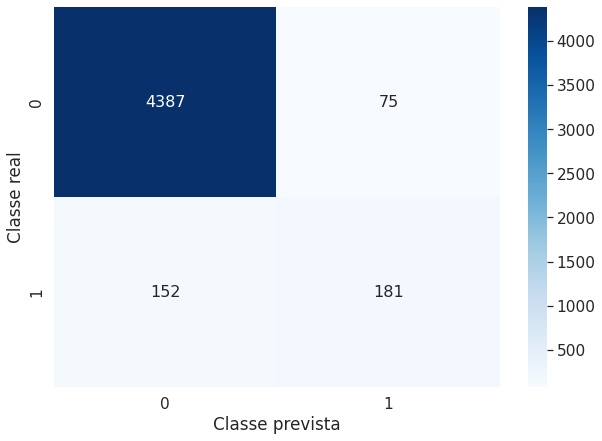

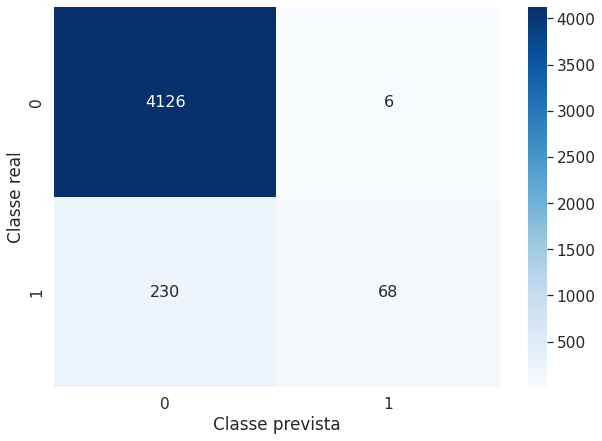

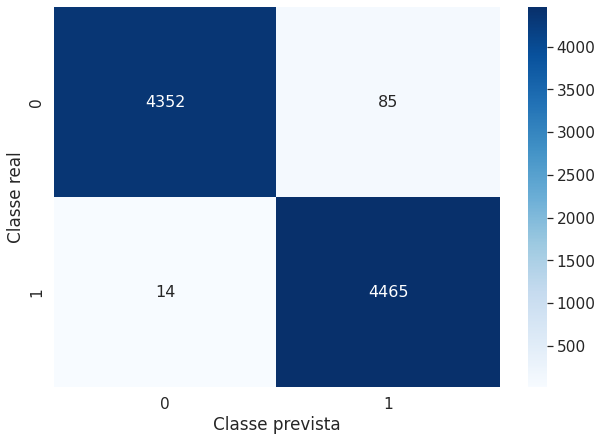

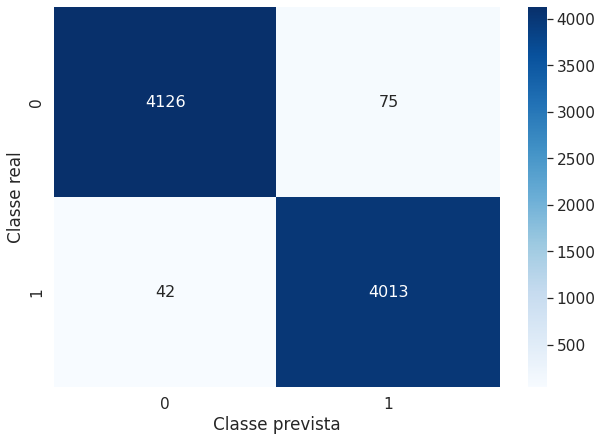

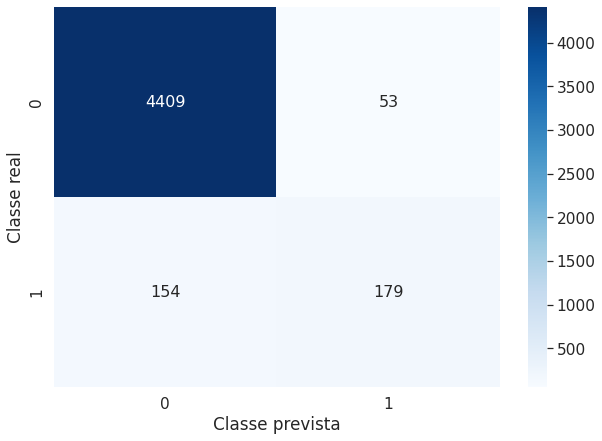

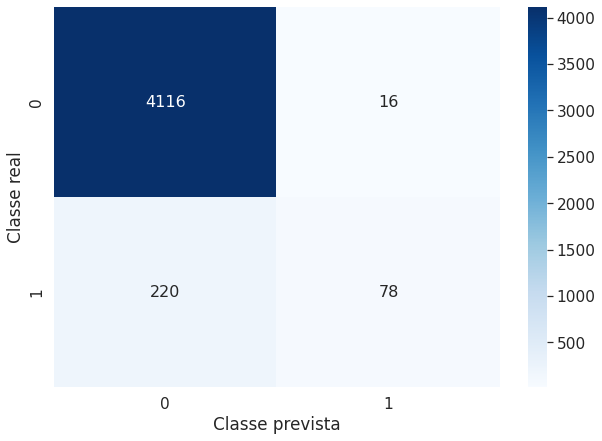

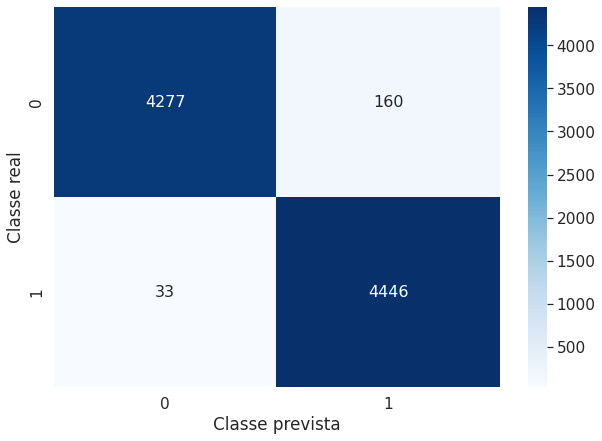

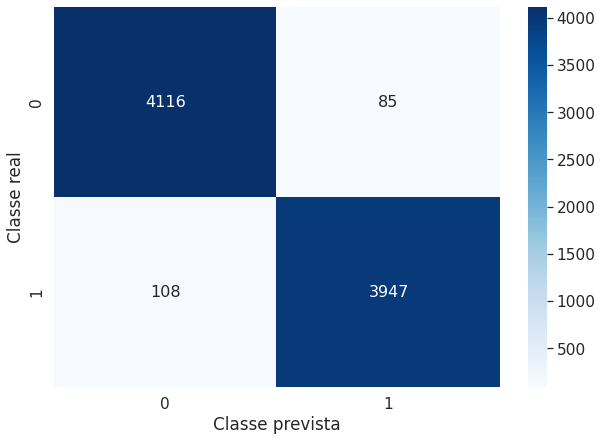

In [29]:
use_augmentation = [False, True]
use_preprocessing = [False, True]
models_used = []
preprocessing_used = []
augmentation_used = []
scores_validation = []
tempos = []
models = ['rand', 'non_static']

for model in models:

  for aug in use_augmentation:

    for prep in use_preprocessing:

      if aug and prep:
        vocab_size, tokenizer, X_train, X_validation, y_train, y_validation = preprocessing_step(tokenizer, data_preprocessing_augmentation,  model, prep, aug)
        
      elif aug and not prep:
        vocab_size, tokenizer, X_train, X_validation, y_train, y_validation = preprocessing_step(tokenizer, data_augmentation,  model, prep, aug)
        
      elif prep and not aug:
        vocab_size, tokenizer, X_train, X_validation, y_train, y_validation = preprocessing_step(tokenizer, preprocessed_data,  model, prep, aug)

      else:
        vocab_size, tokenizer, X_train, X_validation, y_train, y_validation = preprocessing_step(tokenizer, normal_data, model, prep, aug) 

      print('Modelo: {}\nPré-processamento: {}\nBalanceamento: {}\n'.format(model, prep, aug))

      if model == 'rand':
        ini = time.time()
        m, history, validation_score = cnn_rand(vocab_size, tokenizer, X_train, X_validation, y_train, y_validation, prep, aug)
        fim = time.time()
        tempo = fim - ini
      elif model == 'static':
        ini = time.time()
        m, history, validation_score = cnn_static(vocab_size, tokenizer, X_train, X_validation, y_train, y_validation, prep, aug)
        fim = time.time()
        tempo = fim - ini
      elif model == 'non_static':
        ini = time.time()
        m, history, validation_score = cnn_non_static(vocab_size, tokenizer, X_train, X_validation, y_train, y_validation, prep, aug)
        fim = time.time()
        tempo = fim - ini
      else:
        print('Modelo não encontrado')
        break
        
      print('Modelo finalizado!\n')

      models_used.append(model)
      tempos.append(tempo)
      preprocessing_used.append(prep)
      augmentation_used.append(aug)
      scores_validation.append(validation_score)

In [30]:
results = pd.DataFrame()
results['modelo'] = models_used
results['tempo'] = tempos
results['pré_processamento'] = preprocessing_used
results['balanceamento'] = augmentation_used
results['score_validação'] = scores_validation

In [31]:
results.head(20)

,modelo,tempo,pré_processamento,balanceamento,score_validação
0,rand,1116.405092,False,False,0.9498
1,rand,960.426370,True,False,0.9314
2,rand,1958.056944,False,True,0.9889
3,rand,1779.546443,True,True,0.9858
4,non_static,1055.199203,False,False,0.9532
5,non_static,996.567754,True,False,0.9335
6,non_static,1961.182383,False,True,0.9783
7,non_static,1779.351538,True,True,0.9766


In [32]:
results.to_csv('tempos_textCNN2D_GPU.csv', index=False)

In [33]:
!zip -r /content/model.zip /content/Model

  adding: content/Model/ (stored 0%)
  adding: content/Model/model_CNN-rand_preprocessing.h5 (deflated 23%)
  adding: content/Model/model_CNN-rand_augmentantion.h5 (deflated 16%)
  adding: content/Model/model_CNN-rand_preprocessing_augmentantion.h5 (deflated 24%)
  adding: content/Model/model_CNN-non-static.h5 (deflated 16%)
  adding: content/Model/model_CNN-rand.h5 (deflated 16%)
  adding: content/Model/model_CNN-non-static_augmentantion.h5 (deflated 15%)
  adding: content/Model/model_CNN-non-static_preprocessing.h5 (deflated 24%)
  adding: content/Model/model_CNN-non-static_preprocessing_augmentantion.h5 (deflated 23%)


In [34]:
!zip -r /content/submission.zip /content/Submission/

  adding: content/Submission/ (stored 0%)
  adding: content/Submission/CNN-rand_preprocessing_augmentation.csv (deflated 72%)
  adding: content/Submission/CNN-non-static.csv (deflated 73%)
  adding: content/Submission/CNN-rand.csv (deflated 73%)
  adding: content/Submission/CNN-rand_preprocessing.csv (deflated 73%)
  adding: content/Submission/CNN-rand_augmentation.csv (deflated 72%)
  adding: content/Submission/CNN-non-static_preprocessing_augmentation.csv (deflated 72%)
  adding: content/Submission/CNN-non-static_preprocessing.csv (deflated 73%)
  adding: content/Submission/CNN-non-static_augmentation.csv (deflated 72%)


In [35]:
!zip -r /content/images_cnn.zip /content/Images/

  adding: content/Images/ (stored 0%)
  adding: content/Images/matriz_confusao_CNN-rand_preprocessing.jpg (deflated 29%)
  adding: content/Images/data_unbalanced.png (deflated 18%)
  adding: content/Images/matriz_confusao_CNN-rand_augmentation.jpg (deflated 31%)
  adding: content/Images/matriz_confusao_CNN-non-static.jpg (deflated 30%)
  adding: content/Images/matriz_confusao_CNN-non-static_preprocessing.jpg (deflated 31%)
  adding: content/Images/matriz_confusao_CNN-rand_preprocessing_augmentation.jpg (deflated 31%)
  adding: content/Images/matriz_confusao_CNN-non-static_preprocessing_augmentation.jpg (deflated 32%)
  adding: content/Images/matriz_confusao_CNN-non-static_augmentation.jpg (deflated 31%)
  adding: content/Images/matriz_confusao_CNN-rand.jpg (deflated 31%)
  adding: content/Images/data_balanced.png (deflated 19%)


In [36]:
!zip -r /content/tokenizer.zip /content/Tokenizer

  adding: content/Tokenizer/ (stored 0%)
  adding: content/Tokenizer/tokenizer.pickle (deflated 54%)


In [ ]:
while True:
  pass

In [ ]:
1+1

## Referências

https://www.kaggle.com/hamishdickson/cnn-for-sentence-classification-by-yoon-kim

https://github.com/pinkeshbadjatiya/twitter-hatespeech/blob/master/cnn.py

https://github.com/alexander-rakhlin/CNN-for-Sentence-Classification-in-Keras/blob/master/sentiment_cnn.py

https://github.com/satya-thirumani/Python/blob/master/Sentiment%20Analysis/AV_practice_problem_Twitter_Sentiment_Analysis.ipynb

https://github.com/yoonkim/CNN_sentence/blob/23e0e1f7355705bb083043fda05c031b15acb38c/conv_net_classes.py#L340

https://github.com/Jverma/cnn-text-classification-keras/blob/master/text_cnn.py

https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/4%20-%20Convolutional%20Sentiment%20Analysis.ipynb

https://github.com/dennybritz/cnn-text-classification-tf/blob/master/text_cnn.py